### Local Modelling
- given the locale's relative SST in the two months leading up to cyclone genesis 
- test two lags (that month and the previous month) to see how 'predictable' it is

In [146]:
import numpy as np
from utils.cyclone_utils import get_cyclone_data

## TODO: use monthly anomaly...
cyclone_df = get_cyclone_data(basin=None, min_cat=0, one_per_id=True)
cyclone_df['is_severe'] = cyclone_df['category'].apply(lambda x: 1 if x >= 3 else 0)
cyclone_df

,id,Time,latitude,longitude,basin,Speed(knots),category,peak_wind,season,is_severe
0,1,1981-07-25 12:00:00,-11.8,86.7,SI,20,1,30,1981-1982,0
13,2,1981-10-21 06:00:00,-8.0,84.6,SI,40,2,85,1981-1982,0
38,3,1981-11-03 18:00:00,-8.6,92.9,SI,55,2,80,1981-1982,0
71,4,1981-12-05 00:00:00,-11.9,125.0,SI,45,1,45,1981-1982,0
74,5,1981-12-29 00:00:00,-9.5,78.8,SI,20,1,45,1981-1982,0
...,...,...,...,...,...,...,...,...,...,...
30412,998,2019-04-03 06:00:00,-8.2,132.3,SP,20,1,60,2018-2019,0
30455,999,2019-04-21 18:00:00,-4.0,79.3,SI,20,3,90,2018-2019,1
30456,1000,2019-04-21 18:00:00,-9.7,52.7,SI,20,4,125,2018-2019,1
30512,1001,2019-05-06 12:00:00,-5.6,129.9,SI,20,1,55,2018-2019,0


## Obtaining the relative SSTs and adding them to the dataframe
Target formula: take local 5 degree average minus the current tropical mean
Steps:
1. obtain 'smooth' SST variable by taking 5 degree average at every coordinate (time and space) in the dataset
2. subtract this variable from the tropical mean SST at that time instant

In [147]:
from utils.globals import SI_MIN, SI_MAX, SP_MIN, SP_MAX
from utils.SST_utils import get_historical_ssts, get_tropical_avg
import seaborn as sns
import matplotlib.pyplot as plt

historical_ssts = get_historical_ssts()
tropical_avg_ssts = get_tropical_avg(historical_ssts)
historical_ssts # 0.2 degree grid
historical_ssts['rSST'] = historical_ssts['sst'] - tropical_avg_ssts['sst']


#### For each cyclone entry, obtain the smoothed local rSST both in the month of genesis and the preceding month

In [158]:
from utils.cyclone_utils import get_datetime
from utils.SST_utils import get_local_smooth_at_time, sel_mm_yyyyy



def get_relative_sst(lat, lon, month, year):
    return get_local_smooth_at_time(historical_ssts['rSST'], lat, lon, month, year)

def filter_nan_from_values(list_obj):
    if len(list_obj) == 0:
        return np.nan
    
    return list_obj[0]

def get_previous_month(month, year):
    if (month == 1):
        return {
            'month': 12,
            'year': year - 1
        }
    return {
        'month': month - 1,
        'year': year
    }


cyclone_df.loc[:,'tropical_SST'] = cyclone_df.apply(
    lambda row: filter_nan_from_values(tropical_avg_ssts['sst'].sel(time=sel_mm_yyyyy(tropical_avg_ssts, get_datetime(row['Time']).month, get_datetime(row['Time']).year)).values), axis=1)
print(cyclone_df)
cyclone_df = cyclone_df.dropna()
cyclone_df.loc[:,'tropical_SST'] = (cyclone_df.loc[:,'tropical_SST'] - cyclone_df['tropical_SST'].mean())/cyclone_df['tropical_SST'].std()

cyclone_df.loc[:,'rSST'] = cyclone_df.apply(
    lambda row: get_local_smooth_at_time(historical_ssts['rSST'], row['latitude'], row['longitude'],  get_datetime(row['Time']).month,  get_datetime(row['Time']).year), axis=1)

# cyclone_df.loc[:,'rSST_lag1'] = cyclone_df.apply(
#     lambda row: 
#     get_local_smooth_at_time(
#         historical_ssts['rSST'],
#         row['latitude'], row['longitude'],  
#         get_previous_month(get_datetime(row['Time']).month, get_datetime(row['Time']).year)['month'],  
#         get_previous_month(get_datetime(row['Time']).month, get_datetime(row['Time']).year)['year']), axis=1)


## NOTE: only take rSSTs above 0 as it's in the cyclone season
cyclone_df = cyclone_df.loc[cyclone_df.loc[:, 'rSST'] >= 0]
cyclone_df

/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_52262/2875426051.py:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  cyclone_df.loc[:,'tropical_SST'] = cyclone_df.apply(


         id                 Time  latitude  longitude basin  Speed(knots)  \
13        2  1981-10-21 06:00:00      -8.0       84.6    SI            40   
38        3  1981-11-03 18:00:00      -8.6       92.9    SI            55   
71        4  1981-12-05 00:00:00     -11.9      125.0    SI            45   
74        5  1981-12-29 00:00:00      -9.5       78.8    SI            20   
101       6  1982-01-06 00:00:00     -12.7      102.9    SI            20   
...     ...                  ...       ...        ...   ...           ...   
30312   997  2019-03-21 18:00:00     -14.1       62.0    SI            25   
30412   998  2019-04-03 06:00:00      -8.2      132.3    SP            20   
30455   999  2019-04-21 18:00:00      -4.0       79.3    SI            20   
30456  1000  2019-04-21 18:00:00      -9.7       52.7    SI            20   
30512  1001  2019-05-06 12:00:00      -5.6      129.9    SI            20   

       category  peak_wind     season  is_severe  tropical_SST      rSST  


,id,Time,latitude,longitude,basin,Speed(knots),category,peak_wind,season,is_severe,tropical_SST,rSST
13,2,1981-10-21 06:00:00,-8.0,84.6,SI,40,2,85,1981-1982,0,-1.084972,1.077494
38,3,1981-11-03 18:00:00,-8.6,92.9,SI,55,2,80,1981-1982,0,-0.921878,0.550992
71,4,1981-12-05 00:00:00,-11.9,125.0,SI,45,1,45,1981-1982,0,-0.832270,2.096899
74,5,1981-12-29 00:00:00,-9.5,78.8,SI,20,1,45,1981-1982,0,-0.832270,1.070588
101,6,1982-01-06 00:00:00,-12.7,102.9,SI,20,3,120,1981-1982,1,-0.926179,0.696194
...,...,...,...,...,...,...,...,...,...,...,...,...
30312,997,2019-03-21 18:00:00,-14.1,62.0,SI,25,3,120,2018-2019,1,1.887371,1.051000
30412,998,2019-04-03 06:00:00,-8.2,132.3,SP,20,1,60,2018-2019,0,2.554131,1.003590
30455,999,2019-04-21 18:00:00,-4.0,79.3,SI,20,3,90,2018-2019,1,2.554131,1.650110
30456,1000,2019-04-21 18:00:00,-9.7,52.7,SI,20,4,125,2018-2019,1,2.554131,1.665155


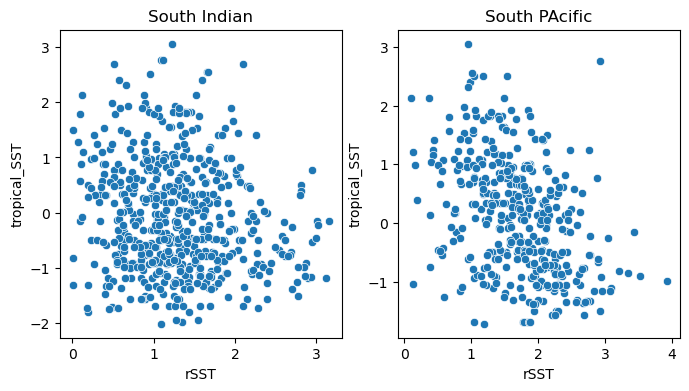

In [167]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
si_df = cyclone_df.loc[cyclone_df.loc[:, 'basin'] == 'SI']
sp_df = cyclone_df.loc[cyclone_df.loc[:, 'basin'] == 'SP']
sns.scatterplot(data=si_df, x='rSST', y='tropical_SST', ax=axs[0]).set(title="South Indian")
sns.scatterplot(data=sp_df, x='rSST', y='tropical_SST', ax=axs[1]).set(title="South PAcific")
plt.show()


/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_52262/2474468683.py:11: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=row_df, x='rSST', hue='category', ax=axs[row][0], common_norm=False, multiple='stack').set(title=(basin))
/var/folders/nk/f4_nbwvd0_vgzc0m31k7tc6m0000gn/T/ipykernel_52262/2474468683.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=row_df, x='tropical_SST', hue='category', ax=axs[row][1], common_norm=False, multiple='stack').set(title=(basin))


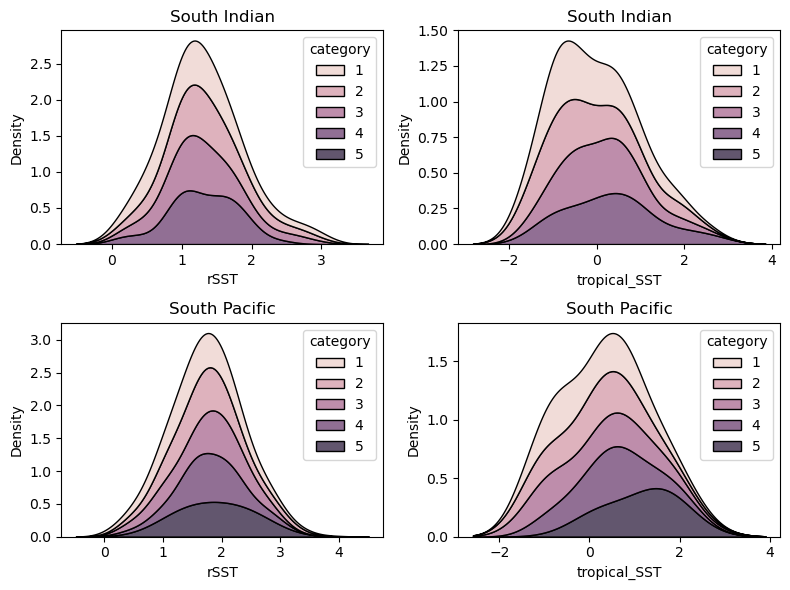

In [150]:
fig, axs = plt.subplots(nrows= 2, ncols=2, figsize=(8,6))
for row in range(len(axs)):
  
    if row == 0:
        row_df = si_df 
        basin = 'South Indian'
    else:
        row_df = sp_df
        basin = 'South Pacific'

    sns.kdeplot(data=row_df, x='rSST', hue='category', ax=axs[row][0], common_norm=False, multiple='stack').set(title=(basin))
    sns.kdeplot(data=row_df, x='tropical_SST', hue='category', ax=axs[row][1], common_norm=False, multiple='stack').set(title=(basin))
    
fig.tight_layout()
# sns.kdeplot(data=sp_df, x='rSST',hue='category', multiple='stack', common_norm=False) ## maybe lag 0 is worth doing???
plt.show()
# sns.kdeplot(data=si_df, x='rSST',hue='category', multiple='stack', common_norm=False) ## maybe lag 0 is worth doing???
# plt.show()

### TODO: effect of interaction between coordinates and lag 0 local rSST on cyclone severity.

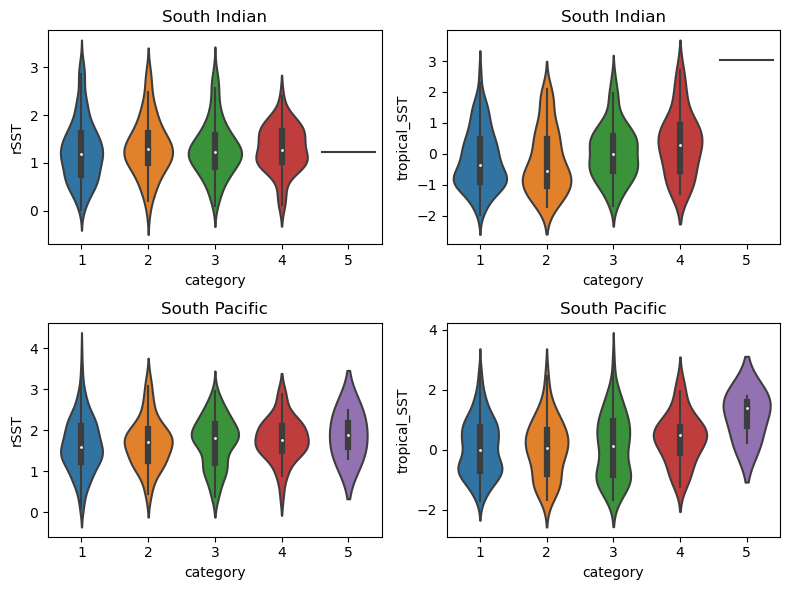

In [152]:
fig, axs = plt.subplots(nrows= 2, ncols=2, figsize=(8,6))
for row in range(len(axs)):
  
    if row == 0:
        row_df = si_df 
        basin = 'South Indian'
    else:
        row_df = sp_df
        basin = 'South Pacific'

    sns.violinplot(data=row_df, x='category', y='rSST', ax=axs[row][0]).set(title=(basin))
    sns.violinplot(data=row_df, x='category', y='tropical_SST', ax=axs[row][1]).set(title=(basin))
    
fig.tight_layout()
# sns.kdeplot(data=sp_df, x='rSST',hue='category', multiple='stack', common_norm=False) ## maybe lag 0 is worth doing???
plt.show()

# sns.catplot(data=si_df, x='category', y='rSST', kind='violin')
# sns.catplot(data=sp_df, x='category', y='rSST', kind='violin')

   quantile   intercept          rSST  tropical_SST   rSST_lb    rSST_ub  \
0      0.05   35.000000  3.489040e-07  2.651147e-07 -3.679455   3.679456   
1      0.15   36.166095  2.122171e+00  2.353918e+00 -1.350365   5.594707   
2      0.25   40.532499  3.644511e+00  2.746921e+00 -0.255433   7.544455   
3      0.35   46.326793  4.346515e+00  4.389529e+00 -0.189383   8.882413   
4      0.45   52.041525  5.426519e+00  6.051840e+00  0.032030  10.821008   
5      0.55   57.676543  9.152832e+00  7.233955e+00  2.333825  15.971839   
6      0.65   78.456439  5.948150e+00  1.150876e+01 -3.060512  14.956812   
7      0.75   94.506474  4.247781e+00  1.129620e+01 -2.668530  11.164093   
8      0.85  106.391738  5.614596e+00  7.238932e+00  0.404882  10.824309   
9      0.95  128.435154  1.091673e+00  7.019933e+00 -3.317774   5.501120   

   tropical_SST_lb  tropical_SST_ub  
0        -1.986349         1.986349  
1         0.333985         4.373850  
2         0.469328         5.024514  
3         1

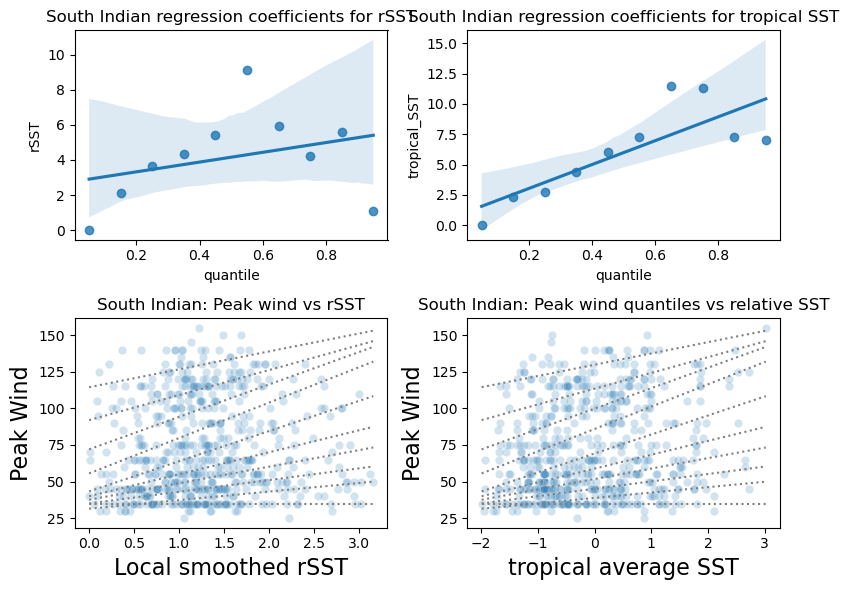

   quantile   intercept          rSST  tropical_SST   rSST_lb    rSST_ub  \
0      0.05   35.000000 -6.268374e-09  5.689676e-09 -5.794574   5.794574   
1      0.15   40.000000 -1.018002e-08  6.307364e-08 -5.343043   5.343043   
2      0.25   45.000000  3.204760e-07 -1.639777e-08 -5.567061   5.567062   
3      0.35   47.795177  2.936291e+00  1.797764e+00 -3.195615   9.068196   
4      0.45   48.693063  6.087688e+00  2.062101e+00 -0.804072  12.979449   
5      0.55   54.203297  8.112271e+00  3.456386e+00 -0.005176  16.229719   
6      0.65   54.825459  1.464835e+01  7.024568e+00  4.898043  24.398651   
7      0.75   64.116769  1.857638e+01  1.044378e+01  8.125035  29.027729   
8      0.85   84.154448  1.651129e+01  7.982427e+00  7.655884  25.366703   
9      0.95  105.420918  1.273532e+01  1.383990e+01  5.435317  20.035314   

   tropical_SST_lb  tropical_SST_ub  
0        -3.115427         3.115427  
1        -3.106795         3.106796  
2        -3.371651         3.371651  
3        -1

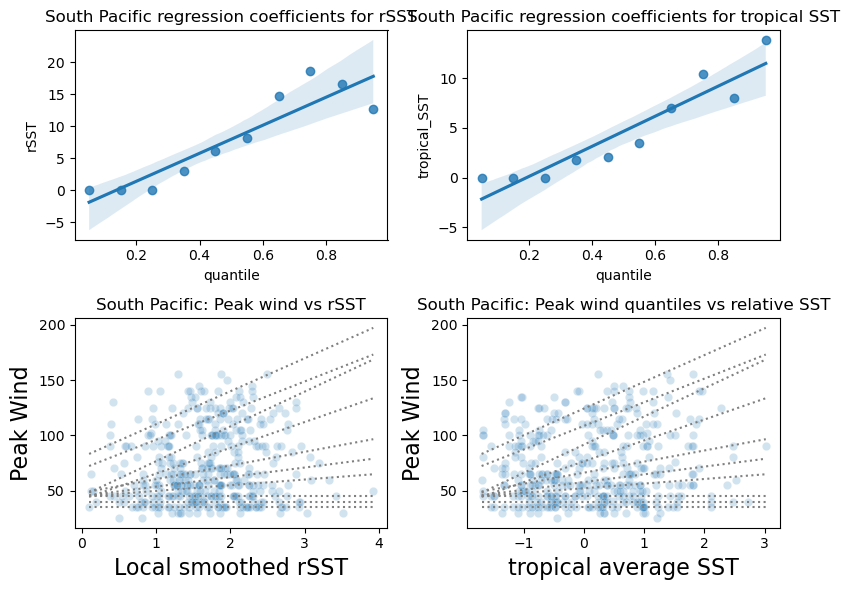

In [157]:
# basic logistic regressor on lag 0 sst smoothed 
# TODO: Quantile regression -> top 10% of cyclones will look like??
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd

quantiles = np.arange(0.05, 0.96, 0.1)
def fit_model(quantile, model):
    res = model.fit(q=quantile)
    return [quantile, res.params["Intercept"], res.params["rSST"], res.params['tropical_SST']] + res.conf_int().loc[
        "rSST"
    ].tolist() + res.conf_int().loc[
        "tropical_SST"
    ].tolist()


for ent in [{'df': si_df, 'basin': 'South Indian'}, {'df': sp_df, 'basin': 'South Pacific'}]:
    fig, axs = plt.subplots(nrows= 2, ncols=2, figsize=(8,6))
    df = ent['df']
    basin = ent['basin']
    model = smf.quantreg('peak_wind ~ rSST + tropical_SST', data=df)

    models = [fit_model(x, model) for x in quantiles]
    models = pd.DataFrame(models, columns=["quantile", "intercept", "rSST", "tropical_SST", "rSST_lb", "rSST_ub", "tropical_SST_lb", "tropical_SST_ub"])

    print(models)

    sns.regplot(data=models, x="quantile", y="rSST", ax=axs[0][0]).set(title =f'{basin} regression coefficients for rSST')
    sns.regplot(data=models, x="quantile", y="tropical_SST", ax=axs[0][1]).set(title = f'{basin} regression coefficients for tropical SST')

    rSST_x = np.linspace(df['rSST'].min(), df['rSST'].max(), 100)
    tropical_SST_x = np.linspace(df['tropical_SST'].min(), df['tropical_SST'].max(), 100)

    for i in range(models.shape[0]):
        y = models.intercept[i] + models.rSST[i] * rSST_x + models.tropical_SST[i] * tropical_SST_x
        axs[1][0].plot(rSST_x, y, linestyle="dotted", color="grey")
        axs[1][1].plot(tropical_SST_x, y, linestyle="dotted", color="grey")

    sns.scatterplot(data=df, x='rSST', y='peak_wind', alpha=0.2, ax=axs[1][0]).set(title =f'{basin}: Peak wind vs rSST')
    sns.scatterplot(data=df, x='tropical_SST', y='peak_wind', alpha=0.2, ax=axs[1][1]).set(title =f'{basin}: Peak wind vs tropical average')

    plt.title(f'{basin}: Peak wind quantiles vs relative SST')
    axs[1][0].set_xlabel("Local smoothed rSST", fontsize=16)
    axs[1][0].set_ylabel("Peak Wind", fontsize=16)

    axs[1][1].set_xlabel("tropical average SST", fontsize=16)
    axs[1][1].set_ylabel("Peak Wind", fontsize=16)
    fig.tight_layout()

    plt.show()



In [ ]:
from utils.SST_utils import get_local_smooth_month_avg 


month_tropical_avg_dict = {}
for month in range(1,13):
    month_tropical_avg_dict[month] = tropical_avg_ssts['sst'].sel(time=tropical_avg_ssts.time.dt.month == month).mean('time').values

def get_monthly_rsst_anomaly(curr_rSST, month, lat, lon): #VERRRY SLOWWWWW -- how to parallelise the .apply??
    month_avg = get_local_smooth_month_avg(historical_ssts['sst'], lat, lon, month)
    print(month_avg)
    return curr_rSST - (month_avg - month_tropical_avg_dict[month])
    

cyclone_df.loc[:,'monthly_rSST_anomaly'] = cyclone_df.apply(lambda row: get_monthly_rsst_anomaly(row['rSST'], get_datetime(row['Time']).month, row['latitude'], row['longitude']), axis=1)
cyclone_df

27.789015
27.789015
27.705639
27.705639
29.850414
29.850414
28.242989
28.242989
27.75773
27.75773
28.36212
28.36212
28.607016
28.607016
29.62346
29.62346
27.346598
27.346598
28.118216
28.118216
28.20943
28.20943
28.401493
28.401493
27.868958
27.868958
29.328743
29.328743
28.447483
28.447483
28.15896
28.15896
28.206667
28.206667
28.514889
28.514889
28.64663
28.64663
29.36793
29.36793
29.100292
29.100292
29.117208
29.117208
28.958897
28.958897
28.709333
28.709333
29.07841
29.07841
27.731865
27.731865
28.777224
28.777224
28.156343
28.156343
28.58531
28.58531
28.71435
28.71435
29.46066
29.46066
28.960514
28.960514
27.849043
27.849043
29.404947
29.404947
28.518044
28.518044
29.033806
29.033806
29.034021
29.034021
29.404951
29.404951
28.914118
28.914118
29.290203
29.290203
28.771614
28.771614
29.368868
29.368868
28.268856
28.268856
28.001055
28.001055
28.320099
28.320099
28.832212
28.832212
28.650318
28.650318
26.973978
26.973978
26.823397
26.823397
28.196278
28.196278
28.032751
28.032751
28

,id,Time,latitude,longitude,basin,Speed(knots),category,peak_wind,season,is_severe,local_SST,rSST,monthly_rSST_anomaly
13,2,1981-10-21 06:00:00,-8.0,84.6,SI,40,2,85,1981-1982,0,27.843523,1.077494,0.200512
38,3,1981-11-03 18:00:00,-8.6,92.9,SI,55,2,80,1981-1982,0,27.380234,0.550992,-0.097289
71,4,1981-12-05 00:00:00,-11.9,125.0,SI,45,1,45,1981-1982,0,28.960873,2.096899,-0.723965
74,5,1981-12-29 00:00:00,-9.5,78.8,SI,20,1,45,1981-1982,0,27.934561,1.070588,-0.142850
101,6,1982-01-06 00:00:00,-12.7,102.9,SI,20,3,120,1981-1982,1,27.523769,0.696194,-0.052799
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30312,997,2019-03-21 18:00:00,-14.1,62.0,SI,25,3,120,2018-2019,1,28.969074,1.051000,0.124403
30412,998,2019-04-03 06:00:00,-8.2,132.3,SP,20,1,60,2018-2019,0,29.180096,1.003590,-0.536791
30455,999,2019-04-21 18:00:00,-4.0,79.3,SI,20,3,90,2018-2019,1,29.826614,1.650110,0.011904
30456,1000,2019-04-21 18:00:00,-9.7,52.7,SI,20,4,125,2018-2019,1,29.841661,1.665155,0.581665


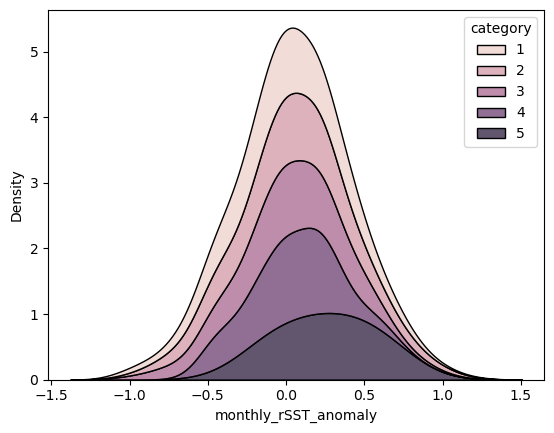

In [ ]:
sns.kdeplot(data=cyclone_df, x='monthly_rSST_anomaly',hue='category', multiple='stack', common_norm=False) ## maybe lag 0 is worth doing???
plt.show()

<Axes: xlabel='monthly_rSST_anomaly', ylabel='peak_wind'>

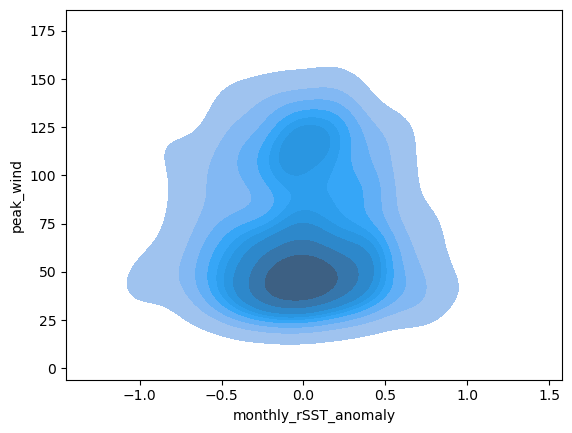

In [ ]:
sns.kdeplot(data=cyclone_df, x='monthly_rSST_anomaly',y='peak_wind', multiple='stack', common_norm=False, fill=True)

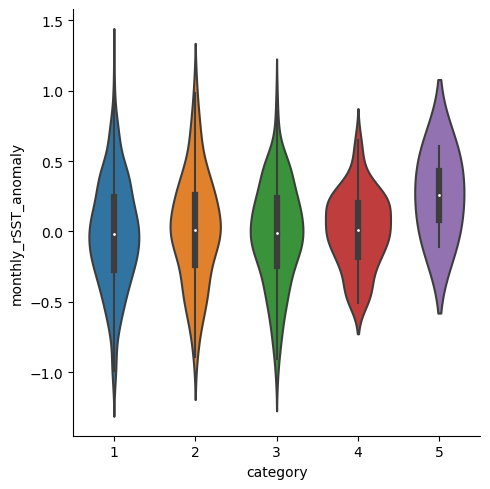

In [ ]:
sns.catplot(data=cyclone_df, x='category', y='monthly_rSST_anomaly', kind='violin')